In [154]:
import pandas as pd
import pickle

In [128]:
import seaborn as sns
import matplotlib.pyplot as plt

In [137]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso

from sklearn.metrics import mean_squared_error


In [91]:
data = pd.read_parquet("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")

In [5]:
!pip install pyarrow

     |████████████████████████████████| 42.7 MB 44.3 MB/s eta 0:00:01


In [60]:
data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.80,1.0,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.30,1.0,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.80,1.0,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.20,1.0,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.60,1.0,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56546,2,2024-01-31 20:46:00,2024-01-31 20:55:00,None,NaN,33,25,NaN,0.00,11.58,0.0,0.0,3.14,0.0,NaN,1.0,15.72,NaN,NaN,NaN
56547,2,2024-01-31 21:06:00,2024-01-31 21:11:00,None,NaN,72,72,NaN,0.49,11.58,0.0,0.0,0.00,0.0,NaN,1.0,12.58,NaN,NaN,NaN
56548,2,2024-01-31 21:36:00,2024-01-31 21:40:00,None,NaN,72,72,NaN,0.52,11.58,0.0,0.0,2.52,0.0,NaN,1.0,15.10,NaN,NaN,NaN
56549,2,2024-01-31 22:45:00,2024-01-31 22:51:00,None,NaN,41,42,NaN,1.17,14.22,0.0,0.0,0.00,0.0,NaN,1.0,15.22,NaN,NaN,NaN


In [130]:
def read_dataFrame(filename):
    data = pd.read_parquet(filename)
    #df = data.lpep_dropoff_datetime - data.lpep_dropoff_datetime
    
    data["duration"] = data.lpep_dropoff_datetime - data.lpep_pickup_datetime
    data.duration = data.duration.apply(lambda td: td.total_seconds()/60)
    
    data = data[(data.duration >= 1) & (data.duration <= 60)]
    
    categorical = ['PULocationID', 'DOLocationID']
    data[categorical] = data[categorical].astype(str)
    
    return data


In [131]:
df_train = read_dataFrame("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")
df_val = read_dataFrame("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")


In [132]:
len(df_train), len(df_val)

(54373, 51497)

In [68]:
#data = data[data.trip_type == 2]

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

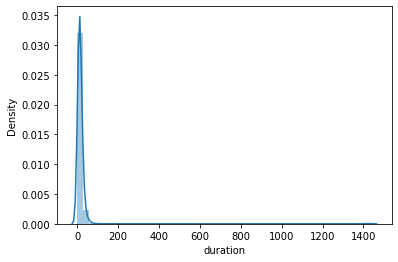

In [70]:
sns.distplot(data.duration)

In [97]:
((data.duration >= 1) & (data.duration <= 60)).mean()

0.9614860921999611

In [100]:
data[categorical].dtypes

PULocationID    int32
DOLocationID    int32
dtype: object

In [147]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [148]:
categorical = ['PU_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)


In [134]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [149]:

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

5.982652114977233

In [158]:
with open('/workspaces/mlops/models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)
    

In [153]:

lr = Lasso(alpha=0.0001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

6.008120318390882

/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/codespace/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


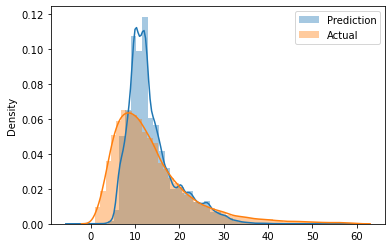

In [118]:
sns.distplot(y_pred, label='Prediction')
sns.distplot(y_train, label='Actual')

plt.legend()